# Tutorial notebook for training photometry->surface params models and doing transfer learning for surface params->age and mass models

(work in progress)

In [1]:
# IMPORT LIBRARIES

import random as rn
import numpy as np
import math as mt

import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits import mplot3d
%matplotlib inline

import pylab as pl
import sys
#from matplotlib.pyplot import cm
#import glob
import pandas as pd

#from astropy.table import Table

#import torch
#import torch.nn as nn
import StelNet as st

We can give the age/mass component of StelNet information about new datasets using `st.transfer_learning_bootstraps()`. As an example, let's do transfer learning on the baseline models with the David & Hillenbrand sample of stellar ages and masses and Godoy-Rivera sample of subgiants.

In [2]:
## load D&H stars:
dh_data_raw = pd.read_csv('Data/postZAMS/DH.csv') 
dh_df = pd.DataFrame(dh_data_raw)
dh_df['teff_log'] = np.log10(dh_df['Teff'].astype(float))
dh_df['lum_log'] = np.log10(dh_df['lum_val'].astype(float))

dh_df['ageyr'] = dh_df['Ageavg']*1e+6
dh_df['logAge'] = np.log10(dh_df['ageyr'])
dh_df['logMass'] = np.log10(dh_df['Mavg'])

Data_dh = dh_df[['teff_log','lum_log', 'logAge', 'logMass']].dropna().values.astype(float)

## load G-R subgiants:
gr_data_raw = pd.read_csv('Data/postZAMS/G-R.csv') 
gr_df = pd.DataFrame(gr_data_raw)
gr_df['teff_log'] = np.log10(gr_df['Teff'].astype(float))
gr_df['lum_log'] = np.log10(gr_df["Luminosity"].astype(float)) 

gr_df['ageyr'] = gr_df['Age']*1e+9
gr_df['logAge'] = np.log10(gr_df['ageyr'])   
gr_df['logMass'] = np.log10(gr_df['Mass'])

Data_gr = gr_df[['teff_log','lum_log', 'logAge', 'logMass']].dropna().values.astype(float)

In [3]:
print(len(Data_dh))
print(len(Data_gr))

1869
340


The function requires a list of arrays to be used for transfer learning. In addition, it needs the approximate number of stars from each catalog that we'd like to use in training. For this example, let's take ~50 stars from the D&H catalog and ~20 from the G-R catalog.

To anchor the model's predictions to stellar evolution theory where we don't have new data, we also add some random datapoints from MIST

**Note, in future it might make sense to use more stars from each catalog (not mist)--an 80%/20% train/test split is common (and could be hard coded into StelNet.py so that you distinguish between the training and testing, and only visualize results with the test data); this is an experiment using way way less than that for training.

In [4]:
datasets = [Data_dh, Data_gr]
n_trs = [50,20] # number of stars to draw from each catalog
n_trs_mist = 50 # number of MIST stars to include

We specify a `modelname`, a path for the new models we generate to get saved to when the function is run; all n bootstraps will get saved here, numbered 0-(n-1). We assume 20 bootstraps, and set the number of iterations to train for, `n_it`.

In [5]:
modelname = "Models/TL/new_TL/github_example/postms_tl_example"
n_it=100

Running the function below, note that we specify `stage="post"` because we want to re-train post-ZAMS models

In [6]:
st.transfer_learning_bootstraps(data=datasets, n_trs=n_trs, n_trs_mist=n_trs_mist,
                                modelname=modelname, stage="post", n_it=n_it, verbose=True)

training model # -1
[iteration 0010] loss: 0.5329
[iteration 0020] loss: 0.0812
[iteration 0030] loss: 0.0974
[iteration 0040] loss: 0.0515
[iteration 0050] loss: 0.0424
[iteration 0060] loss: 0.0396
[iteration 0070] loss: 0.0365
[iteration 0080] loss: 0.0342
[iteration 0090] loss: 0.0328
[iteration 0100] loss: 0.0316
training model # 0
[iteration 0010] loss: 0.1021
[iteration 0020] loss: 0.0473
[iteration 0030] loss: 0.0391
[iteration 0040] loss: 0.0295
[iteration 0050] loss: 0.0267
[iteration 0060] loss: 0.0257
[iteration 0070] loss: 0.0247
[iteration 0080] loss: 0.0240
[iteration 0090] loss: 0.0235
[iteration 0100] loss: 0.0231
training model # 1
[iteration 0010] loss: 0.1126
[iteration 0020] loss: 0.0509
[iteration 0030] loss: 0.0431
[iteration 0040] loss: 0.0355
[iteration 0050] loss: 0.0331
[iteration 0060] loss: 0.0320
[iteration 0070] loss: 0.0304
[iteration 0080] loss: 0.0294
[iteration 0090] loss: 0.0288
[iteration 0100] loss: 0.0282
training model # 2
[iteration 0010] loss: 

The easiest way to use new models is to add the model path as a transfer learning option in `StelNet.py`. See the `predict_age_mass()` function for the application of this example, where we set a new option for `TL="example"`. Now we can make predictions with this new model of StelNet, say, for the FGK benchmarks:

In [9]:
data_raw = pd.read_csv('Data/postZAMS/FGK.csv') 
df = pd.DataFrame(data_raw)
df['teff_log'] = np.log10(df['Teff'].astype(float))
df['lum_log'] = df["Lum"].astype(float)  # luminosity column is already log scaled in this file

df['ageyr'] = df['med_age']*1e+9
df['logAge'] = np.log10(df['ageyr'])   
df['logMass'] = np.log10(df['M'])

Data = df[['teff_log','lum_log', 'logAge', 'logMass']].dropna().astype(float)


data_x = Data[['teff_log','lum_log']]
data_y = Data[['logAge','logMass']]

data = data_x.values.astype('float')
data_0 = np.copy(data)

In [12]:
# Predict with a number (num_models) bootsptrap for both the pre-ZAMS and the post-ZAMS 
num_NNs=20
y_pre, y_post= st.predict_age_mass(data, n=num_NNs, TL="example")

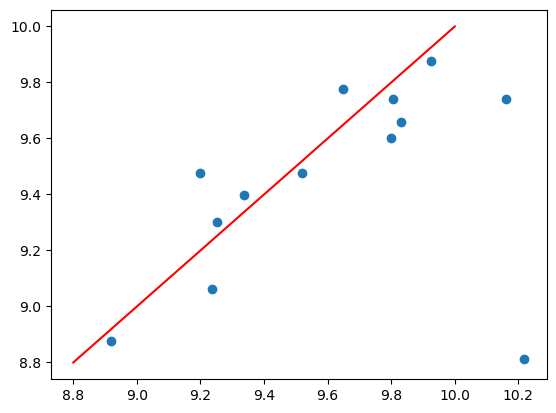

In [13]:
# compute stats
y_mean_preMS, y_std_preMS = st.stats(y_pre)
y_mean_postMS, y_std_postMS = st.stats(y_post)

# plot
fig, ax = plt.subplots()

x = y_mean_postMS[:,0] # predicted
y = data_y['logAge']

ax.scatter(x,y)

z = np.linspace(8.8,10,2)
ax.plot(z,z,color='r')